In this notebook we want to predict different arrhytmia on ECG. We have two different datasets. source of data is MIT_BIH Arrhythmia Database. link - https://physionet.org/content/mitdb/1.0.0/ . Here we will implement machine learning models to classify the given data of heartbit into different classes . As given in dataset we provided with five different classes of heartbit [N:0, S:1, V:2, F:3, Q:4].

N: Non-Ectopic Beats

S: Superventricular Ectopic Beats

V: Ventricular Ectopic Beats

F: Fusion Beats

Q: Unknown Beats

## ALL LOADING OF MODELS AND LIBREARIES ARE HERE

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from keras.layers import Conv1D, MaxPooling1D, Flatten, BatchNormalization, Dense
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score ,  f1_score, precision_score, recall_score
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import warnings

# LOADING TRAIN AND TEST DATASET

In [2]:
train = pd.read_csv('mitbih_train.csv',header=None)
test = pd.read_csv('mitbih_test.csv', header=None)

# EDA

In [3]:
train.shape

(87554, 188)

In [4]:
test.shape

(21892, 188)

In [5]:
train.info

<bound method DataFrame.info of             0         1         2         3         4         5         6    \
0      0.977941  0.926471  0.681373  0.245098  0.154412  0.191176  0.151961   
1      0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
2      1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   
3      0.925414  0.665746  0.541436  0.276243  0.196133  0.077348  0.071823   
4      0.967136  1.000000  0.830986  0.586854  0.356808  0.248826  0.145540   
...         ...       ...       ...       ...       ...       ...       ...   
87549  0.807018  0.494737  0.536842  0.529825  0.491228  0.484211  0.456140   
87550  0.718333  0.605000  0.486667  0.361667  0.231667  0.120000  0.051667   
87551  0.906122  0.624490  0.595918  0.575510  0.530612  0.481633  0.444898   
87552  0.858228  0.645570  0.845570  0.248101  0.167089  0.131646  0.121519   
87553  0.901506  0.845886  0.800695  0.748552  0.687138  0.599073  0.512167   

            7         8         9    ...  178  179  180  181  182  183  184  \
0      0.085784  0.058824  0.049020  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1      0.088319  0.074074  0.082621  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2      0.043243  0.054054  0.045946  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3      0.060773  0.066298  0.058011  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4      0.089202  0.117371  0.150235  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...         ...       ...       ...  ...  ...  ...  ...  ...  ...  ...  ...   
87549  0.396491  0.284211  0.136842  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
87550  0.001667  0.000000  0.013333  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
87551  0.387755  0.322449  0.191837  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
87552  0.121519  0.118987  0.103797  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
87553  0.427578  0.395133  0.402086  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       185  186  187  
0      0.0  0.0  0.0  
1      0.0  0.0  0.0  
2      0.0  0.0  0.0  
3      0.0  0.0  0.0  
4      0.0  0.0  0.0  
...    ...  ...  ...  
87549  0.0  0.0  4.0  
87550  0.0  0.0  4.0  
87551  0.0  0.0  4.0  
87552  0.0  0.0  4.0  
87553  0.0  0.0  4.0  

[87554 rows x 188 columns]>

In [6]:
# train.dropna(subset=[187], inplace=True)
train[187]=train[187].astype(int)

In [7]:
train[187].value_counts()

,count
187,
0,72471
4,6431
2,5788
1,2223
3,641


# EACH CLASS ECG VISUALIZATION

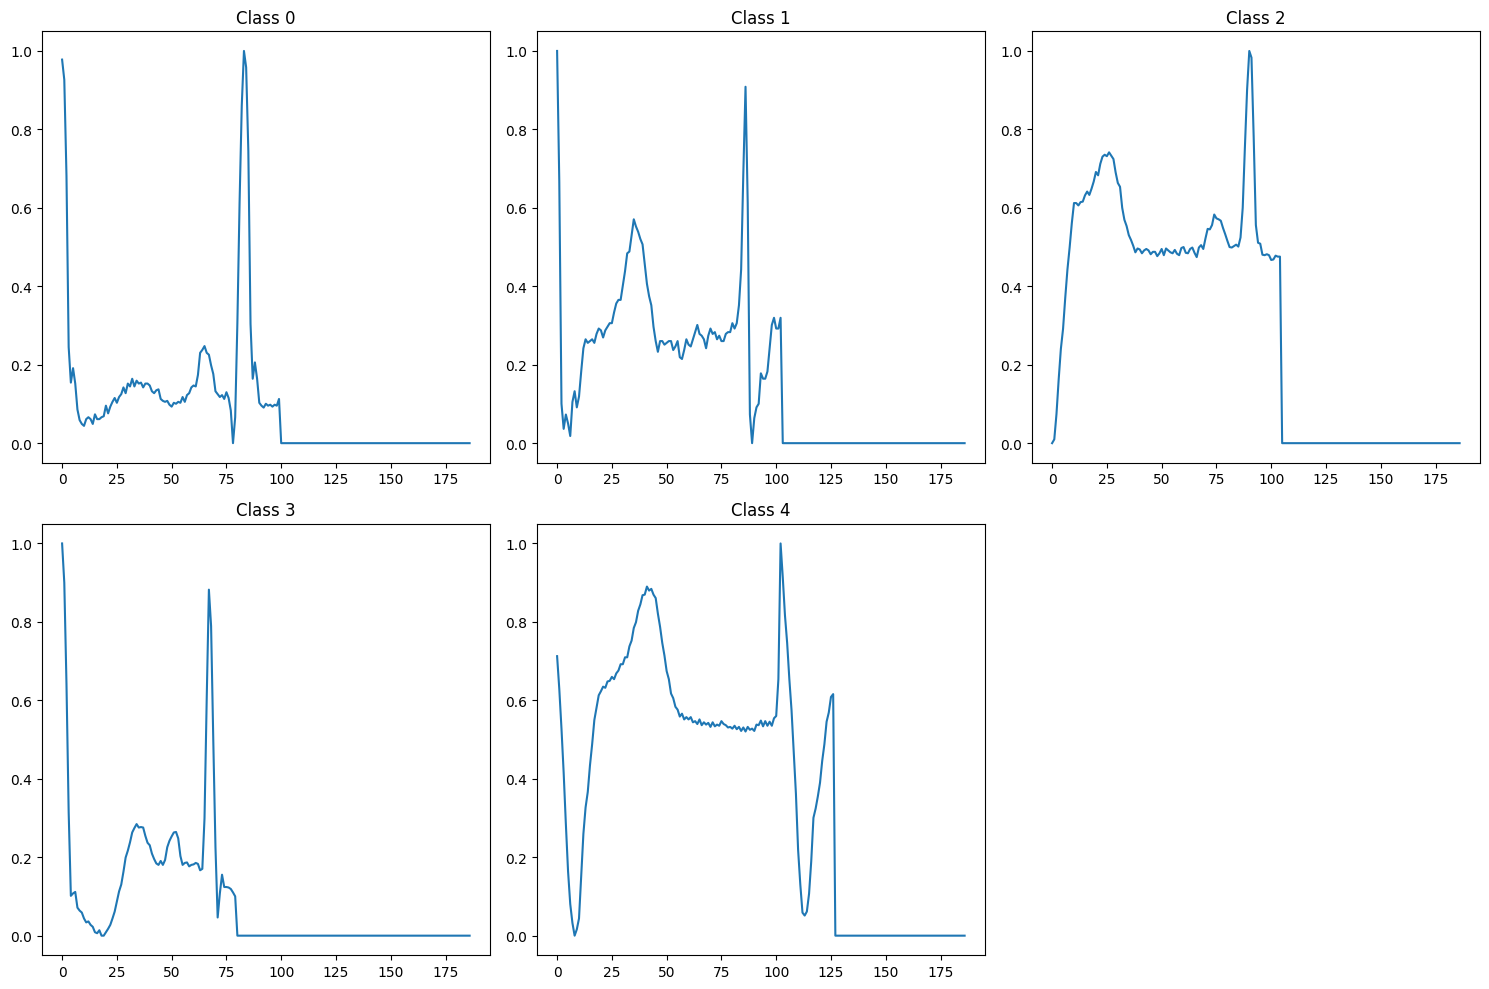

In [8]:
classes = train.iloc[:, -1].unique()
plt.figure(figsize=(15, 10))
for i, cls in enumerate(classes):
    plt.subplot(2, 3, i + 1)
    sample = train[train.iloc[:, -1] == cls].iloc[0, :-1]
    plt.plot(sample.values)
    plt.title(f'Class {cls}')
plt.tight_layout()
plt.show()

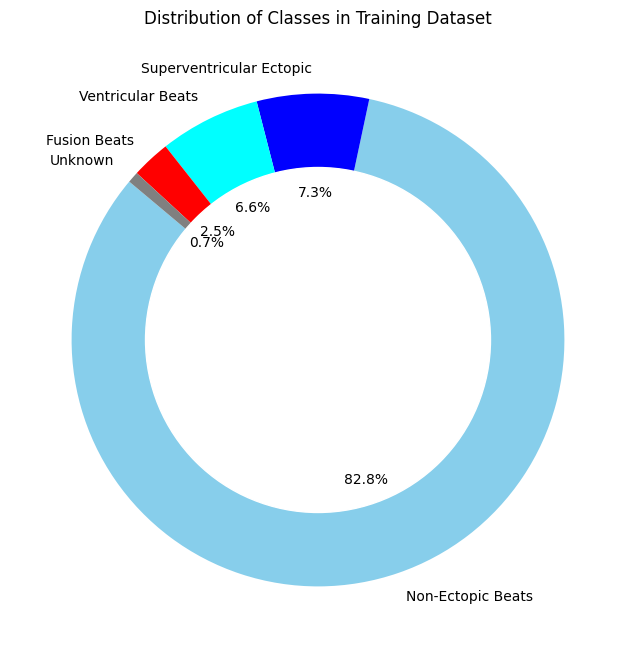

In [9]:
class_counts = train.iloc[:, -1].value_counts()
plt.figure(figsize=(10, 8))
circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(class_counts, labels=['Non-Ectopic Beats', 'Superventricular Ectopic', 'Ventricular Beats',
                              'Fusion Beats', 'Unknown'],
        colors=['skyblue', 'blue', 'cyan', 'red', 'grey'], autopct='%1.1f%%', startangle=140)
p = plt.gcf()
p.gca().add_artist(circle)
plt.title('Distribution of Classes in Training Dataset')
plt.show()

# Data Preprocessing

In [10]:
df_1 = train[train.iloc[:, -1] == 1]
df_2 = train[train.iloc[:, -1] == 2]
df_3 = train[train.iloc[:, -1] == 3]
df_4 = train[train.iloc[:, -1] == 4]

In [11]:
df_1_upsample = resample(df_1, n_samples = 20000, replace = True, random_state = 123)
df_2_upsample = resample(df_2, n_samples = 20000, replace = True, random_state = 123)
df_3_upsample = resample(df_3, n_samples = 20000, replace = True, random_state = 123)
df_4_upsample = resample(df_4, n_samples = 20000, replace = True, random_state = 123)
df_0 = train[train[187]==0].sample(n =20000, random_state=123)
train_df = pd.concat([df_0, df_1_upsample, df_2_upsample, df_3_upsample, df_4_upsample])

In [12]:
train_df[187].value_counts()

,count
187,
0,20000
1,20000
2,20000
3,20000
4,20000


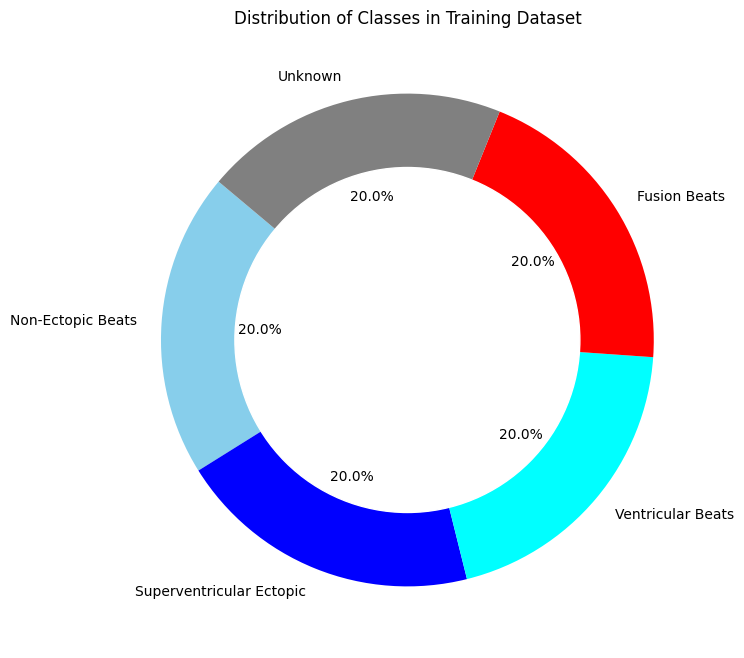

In [13]:
class_counts = train_df.iloc[:, -1].value_counts()
plt.figure(figsize=(10, 8))
circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(class_counts, labels=['Non-Ectopic Beats', 'Superventricular Ectopic', 'Ventricular Beats',
                              'Fusion Beats', 'Unknown'],
        colors=['skyblue', 'blue', 'cyan', 'red', 'grey'], autopct='%1.1f%%', startangle=140)
p = plt.gcf()
p.gca().add_artist(circle)
plt.title('Distribution of Classes in Training Dataset')
plt.show()

<ipython-input-14-69dfd824b4d1>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  c = train.groupby(187,group_keys=False).apply(lambda train : train.sample(1))


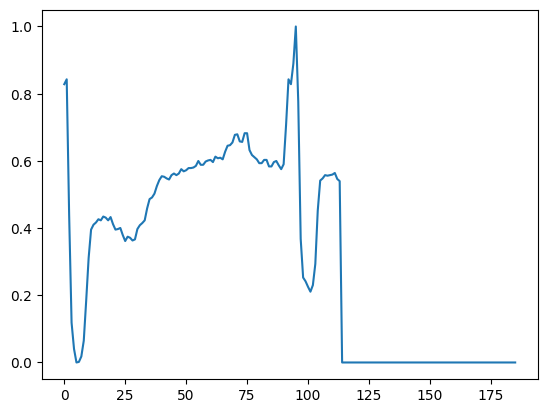

In [14]:
c = train.groupby(187,group_keys=False).apply(lambda train : train.sample(1))
plt.plot(c.iloc[0,:186])

In [15]:
X_train = train_df.iloc[:, :-1].values
X_test = test.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values
y_test = test.iloc[:, -1].values

In [16]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(100000, 187)
(21892, 187)
(100000,)
(21892,)


# Evaluating Normal MACHINE LEARNING Model

In [17]:
train_data_features = train_df.iloc[:, :-1]
train_data_labels = train_df.iloc[:, -1]
test_data_features = test.iloc[:, :-1]
test_data_labels = test.iloc[:, -1]

le = LabelEncoder()
train_data_labels = le.fit_transform(train_data_labels)
test_data_labels = le.transform(test_data_labels)

train_data_features = train_data_features.fillna(train_data_features.mean())
test_data_features = test_data_features.fillna(test_data_features.mean())

scaler = MinMaxScaler()
train_data_features = pd.DataFrame(scaler.fit_transform(train_data_features))
test_data_features = pd.DataFrame(scaler.transform(test_data_features))

pd.DataFrame(train_data_features).to_csv('train_data_features.csv', index=False)
pd.DataFrame(test_data_features).to_csv('test_data_features.csv', index=False)
pd.Series(train_data_labels).to_csv('train_data_labels.csv', index=False)
pd.Series(test_data_labels).to_csv('test_data_labels.csv', index=False)

print("Preprocessing completed. Training and testing datasets are ready.")

Preprocessing completed. Training and testing datasets are ready.


In [18]:
allModels = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Linear SVC": LinearSVC(random_state=42, max_iter=10000),
    "SVC": SVC(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='mlogloss')
}

In [22]:

results = []

for model_name, model in allModels.items():
    print(f"\nTraining {model_name}...")
    model.fit(train_data_features, train_data_labels)
    y_pred = model.predict(test_data_features)

    # Overall metrics
    accuracy = accuracy_score(test_data_labels, y_pred)
    f1 = f1_score(test_data_labels, y_pred, average='weighted')
    precision = precision_score(test_data_labels, y_pred, average='weighted')
    recall = recall_score(test_data_labels, y_pred, average='weighted')

    # Append to results
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall
    })

    # Print per-class report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(test_data_labels, y_pred, target_names=['0','1','2','3','4']))
    # Note: Replace `class_names` with your actual label list, like ['N', 'S', 'V', 'F', 'Q']

# Show summary
results_df = pd.DataFrame(results)
print("\nSummary Metrics:")
print(results_df)


Training Random Forest...

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     18118
           1       0.83      0.73      0.78       556
           2       0.94      0.93      0.94      1448
           3       0.79      0.71      0.75       162
           4       0.98      0.97      0.97      1608

    accuracy                           0.98     21892
   macro avg       0.91      0.87      0.89     21892
weighted avg       0.98      0.98      0.98     21892


Training Linear SVC...

Classification Report for Linear SVC:
              precision    recall  f1-score   support

           0       0.97      0.63      0.76     18118
           1       0.13      0.64      0.22       556
           2       0.31      0.70      0.43      1448
           3       0.07      0.87      0.13       162
           4       0.67      0.92      0.78      1608

    accuracy                           0.66     21892

## DEEP LEARNING MODELS (CNN & MLP)

# CNN (Convonutional Neural Network)

In [28]:
cnn = Sequential()
cnn.add(Conv1D(filters=64, kernel_size=6, activation='relu',padding='same', input_shape=(187, 1)))
cnn.add(BatchNormalization())
cnn.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))
cnn.add(Conv1D(filters=64, kernel_size=6, activation='relu', padding='same'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))
cnn.add(Conv1D(filters=64, kernel_size=6, activation='relu',  padding='same'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))
cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))
cnn.add(Dense(64, activation='relu'))
cnn.add(Dense(5, activation='softmax'))
# Compile The Model
cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [29]:
cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 187, 64)        │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 187, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 94, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 94, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 94, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 47, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 47, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 47, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        98,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,349 (599.02 KB)

 Trainable params: 152,965 (597.52 KB)

 Non-trainable params: 384 (1.50 KB)

In [30]:
# Train The Model
history = cnn.fit(
    X_train, y_train,
    validation_data=(X_test,y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.8984 - loss: 0.2841 - val_accuracy: 0.9554 - val_loss: 0.1454
Epoch 2/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9724 - loss: 0.0792 - val_accuracy: 0.9544 - val_loss: 0.1367
Epoch 3/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9829 - loss: 0.0496 - val_accuracy: 0.9573 - val_loss: 0.1378
Epoch 4/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9878 - loss: 0.0380 - val_accuracy: 0.9518 - val_loss: 0.1856
Epoch 5/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9893 - loss: 0.0323 - val_accuracy: 0.9699 - val_loss: 0.1205
Epoch 6/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9917 - loss: 0.0259 - val_accuracy: 0.9750 - val_loss: 0.1167
Epoch 7/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9934 - loss: 0.0221 - val_accuracy: 0.9738 - val_loss: 0.1362
Epoch 8/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9947 - loss: 0

In [31]:
loss , acc = cnn.evaluate(X_test , y_test)
print('loss:' , loss*100)
print('accuracy: ' , acc*100)

685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9849 - loss: 0.0719
loss: 11.142759770154953
accuracy:  98.11346530914307


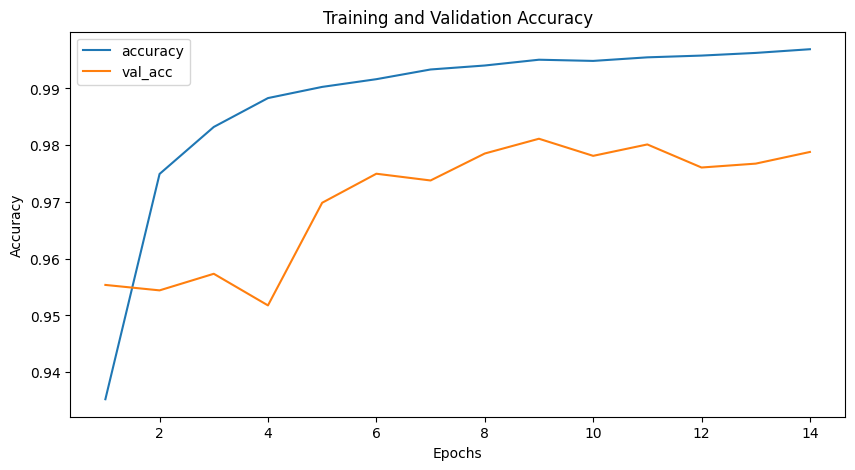

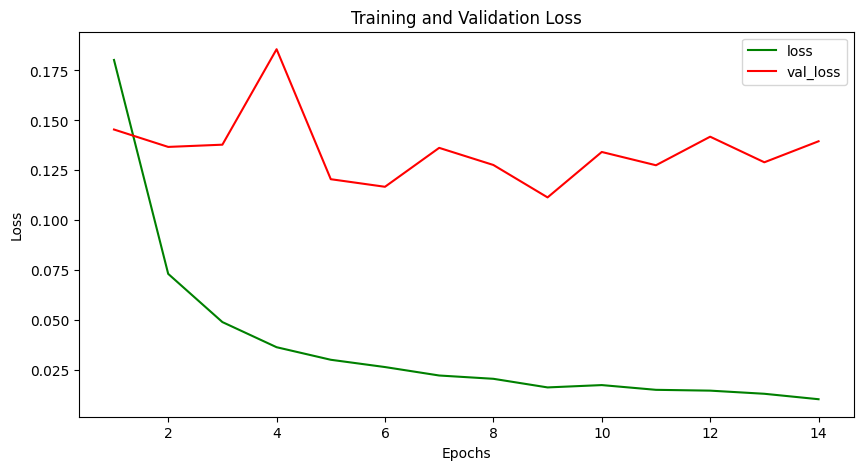

In [32]:
history = history.history
epochs = range(1, len(history['loss']) + 1)
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

plt.figure(figsize=(10, 5))
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend()
plt.figure(figsize=(10, 5))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss', color='g')
plt.plot(epochs, val_loss, label='val_loss', color='r')
plt.legend()

In [33]:
y_pred = cnn.predict(X_test)
y_true = y_test
y_pred_classes = np.argmax(y_pred, axis=1)

685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


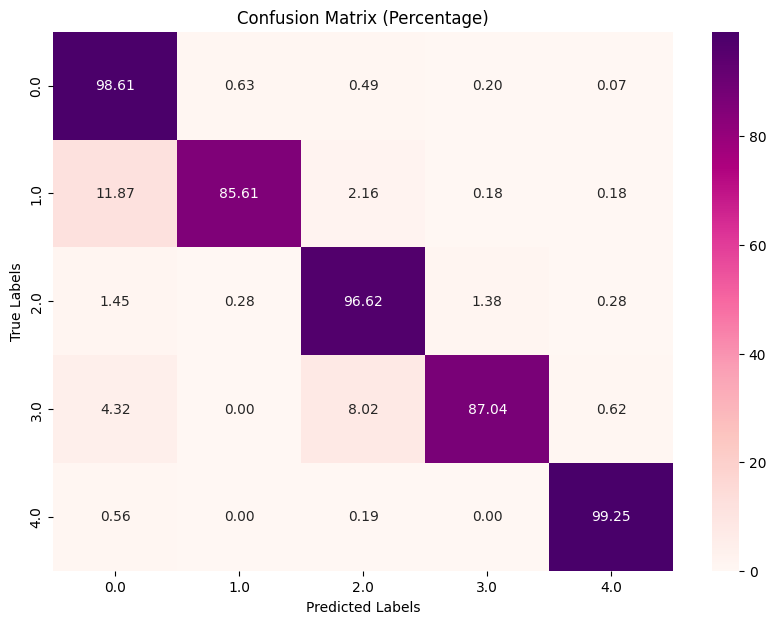

In [34]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
# Plot Confusion Matrix Heatmap (as Percentages)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='RdPu', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [35]:
# Generate Classification Report
report = classification_report(y_true, y_pred_classes)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     18118
         1.0       0.80      0.86      0.83       556
         2.0       0.92      0.97      0.94      1448
         3.0       0.71      0.87      0.78       162
         4.0       0.99      0.99      0.99      1608

    accuracy                           0.98     21892
   macro avg       0.88      0.93      0.91     21892
weighted avg       0.98      0.98      0.98     21892



In [36]:
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.98


# Multi-layer Perceptrion (MLP)

In [37]:
model = Sequential()
model.add(Dense(187,activation='relu' , input_shape=(187,)))
model.add(Dense(100 , activation='relu'))
model.add(Dense(5,activation='softmax'))
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
early_stopping = EarlyStopping( monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 187)            │        35,156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │        18,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,461 (212.74 KB)

 Trainable params: 54,461 (212.74 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
his = model.fit(X_train , y_train ,
                batch_size=128,
                validation_data=(X_test , y_test) ,
                callbacks=[early_stopping],
                epochs=50 ,
                verbose=True)

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9726 - loss: 0.0825 - val_accuracy: 0.9491 - val_loss: 0.1726
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9752 - loss: 0.0760 - val_accuracy: 0.9456 - val_loss: 0.1763
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9773 - loss: 0.0696 - val_accuracy: 0.9504 - val_loss: 0.1704
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9806 - loss: 0.0617 - val_accuracy: 0.9291 - val_loss: 0.2365
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9833 - loss: 0.0530 - val_accuracy: 0.9524 - val_loss: 0.1690
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9852 - loss: 0.0478 - val_accuracy: 0.9355 - val_loss: 0.2298
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9848 - loss: 0.0491 - val_accuracy: 0.9444 - val_loss: 0.2016
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9859 - loss: 0.0458 - val_accuracy: 0.

In [48]:
loss , acc = model.evaluate(X_test , y_test)
print('loss:' , loss*100)
print('accuracy: ' , acc*100)

685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9737 - loss: 0.0867
loss: 14.05802071094513
accuracy:  96.67001366615295


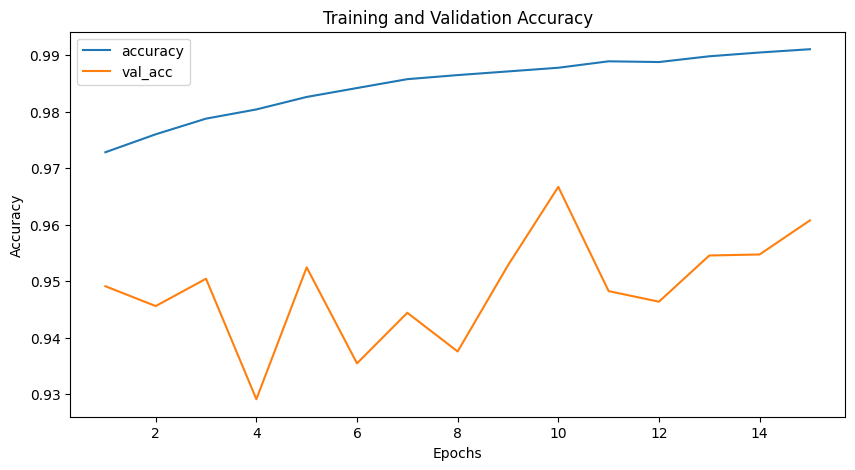

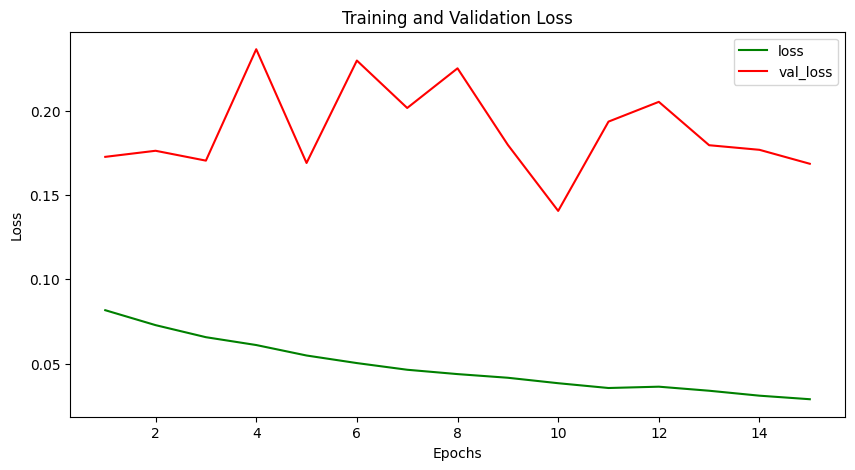

In [49]:
hist = his.history
epochs = range(1, len(hist['loss']) + 1)
acc = hist['accuracy']
loss = hist['loss']
val_acc = hist['val_accuracy']
val_loss = hist['val_loss']

plt.figure(figsize=(10, 5))
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend()
plt.figure(figsize=(10, 5))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss', color='g')
plt.plot(epochs, val_loss, label='val_loss', color='r')
plt.legend()

In [50]:
y_pred = model.predict(X_test)
y_true = y_test
y_pred_classes = np.argmax(y_pred, axis=1)

685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


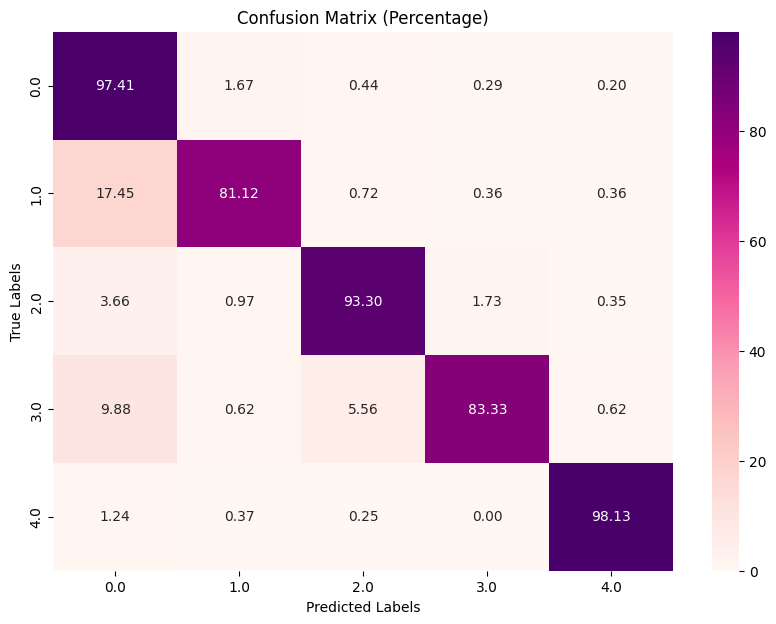

In [51]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot Confusion Matrix Heatmap (as Percentages)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='RdPu',
            xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [52]:
# Generate Classification Report
report = classification_report(y_true, y_pred_classes)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     18118
         1.0       0.58      0.81      0.68       556
         2.0       0.93      0.93      0.93      1448
         3.0       0.63      0.83      0.72       162
         4.0       0.97      0.98      0.98      1608

    accuracy                           0.97     21892
   macro avg       0.82      0.91      0.86     21892
weighted avg       0.97      0.97      0.97     21892



In [53]:
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.97


# CREATING NEW DATASET FOR REDUCE NUMBER AND TRAIN AGAIN

In [46]:
train = pd.read_csv('mitbih_train.csv',header=None)
test = pd.read_csv('mitbih_test.csv', header=None)

In [55]:
df_class_0 = train.groupby(187).apply(lambda x: x.sample(n=600, random_state=42)).reset_index(drop=True)


<ipython-input-55-3730551ec063>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_class_0 = train.groupby(187).apply(lambda x: x.sample(n=600, random_state=42)).reset_index(drop=True)


In [56]:
df_class_0

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.162791,0.540698,0.755814,0.186047,0.168605,0.546512,0.616279,0.697674,0.651163,0.703488,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.990066,0.938742,0.344371,0.034768,0.273179,0.331126,0.326159,0.341060,0.347682,0.347682,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.974239,0.932084,0.590164,0.131148,0.014052,0.168618,0.238876,0.210773,0.196721,0.208431,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.978495,0.723118,0.526882,0.298387,0.220430,0.158602,0.091398,0.091398,0.080645,0.083333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.963351,0.709424,0.060209,0.013089,0.057592,0.041885,0.047120,0.034031,0.039267,0.044503,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.676259,0.543165,0.485611,0.478417,0.453237,0.424460,0.384892,0.327338,0.172662,0.100719,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2996,1.000000,0.969014,0.647887,0.394366,0.177465,0.101408,0.095775,0.095775,0.104225,0.104225,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2997,0.390144,0.344969,0.314168,0.299795,0.275154,0.246407,0.217659,0.184805,0.129363,0.055441,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2998,1.000000,0.411321,0.411321,0.366038,0.358491,0.373585,0.354717,0.313208,0.249057,0.173585,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [57]:
df_class_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 4.3 MB


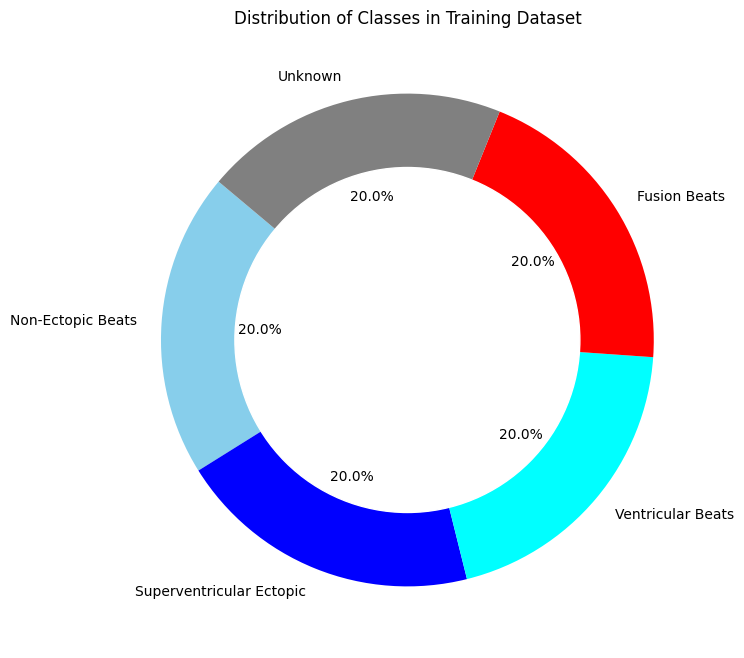

In [84]:
class_counts = df_class_0.iloc[:, -1].value_counts()
plt.figure(figsize=(10, 8))
circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(class_counts, labels=['Non-Ectopic Beats', 'Superventricular Ectopic', 'Ventricular Beats',
                              'Fusion Beats', 'Unknown'],
        colors=['skyblue', 'blue', 'cyan', 'red', 'grey'], autopct='%1.1f%%', startangle=140)
p = plt.gcf()
p.gca().add_artist(circle)
plt.title('Distribution of Classes in Training Dataset')
plt.show()

In [59]:
X_train_new = df_class_0.iloc[:, :-1].values
X_test_new = test.iloc[:, :-1].values
y_train_new = df_class_0.iloc[:, -1].values
y_test_new = test.iloc[:, -1].values

In [63]:
history = cnn.fit(
    X_train_new, y_train_new,
    validation_data=(X_test_new,y_test_new),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9942 - loss: 0.0158 - val_accuracy: 0.9788 - val_loss: 0.1204
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9982 - loss: 0.0047 - val_accuracy: 0.9762 - val_loss: 0.1316
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9992 - loss: 0.0030 - val_accuracy: 0.9751 - val_loss: 0.1350
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9754 - val_loss: 0.1366
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 1.0000 - loss: 6.1543e-04 - val_accuracy: 0.9763 - val_loss: 0.1304
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9765 - val_loss: 0.1343
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


In [64]:
loss , acc = cnn.evaluate(X_test , y_test)
print('loss:' , loss*100)
print('accuracy: ' , acc*100)

685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9820 - loss: 0.0800
loss: 12.039662152528763
accuracy:  97.87593483924866


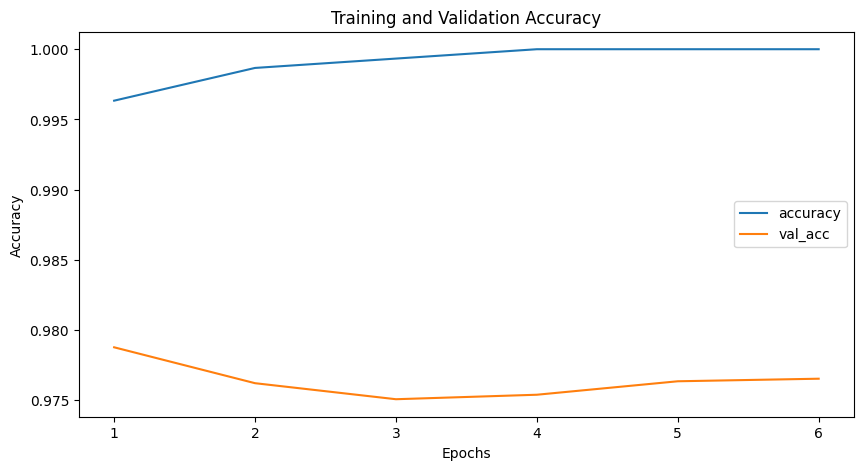

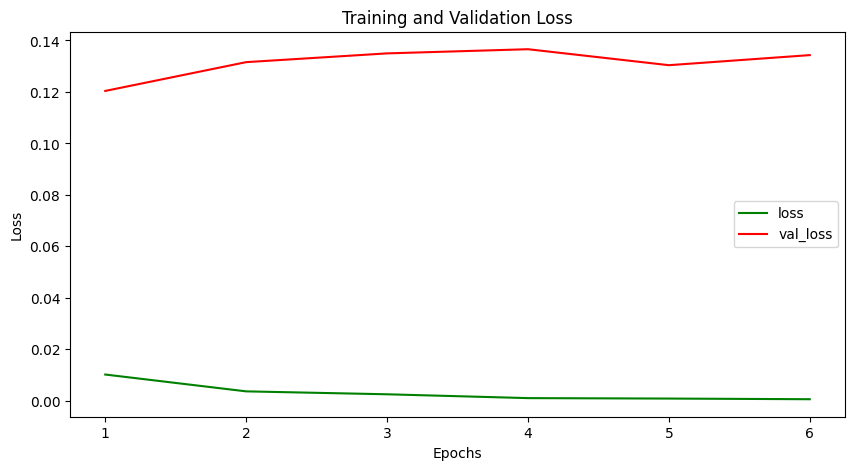

In [65]:
history = history.history
epochs = range(1, len(history['loss']) + 1)
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

plt.figure(figsize=(10, 5))
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend()
plt.figure(figsize=(10, 5))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss', color='g')
plt.plot(epochs, val_loss, label='val_loss', color='r')
plt.legend()

In [66]:
y_pred_new = cnn.predict(X_test_new)
y_true_new = y_test_new
y_pred_classes_new = np.argmax(y_pred_new, axis=1)

685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


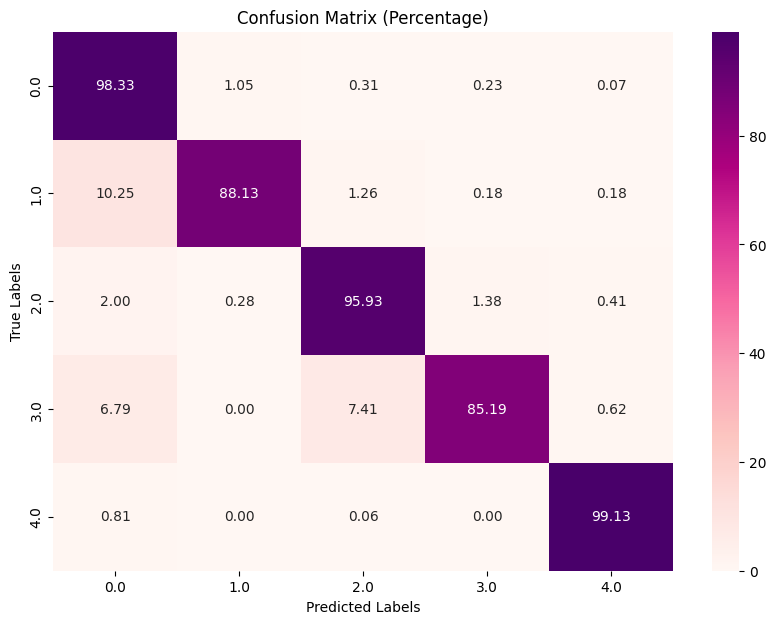

In [67]:
# Confusion Matrix
cm_new = confusion_matrix(y_true_new, y_pred_classes_new)
cm_percentage_new = cm_new.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
# Plot Confusion Matrix Heatmap (as Percentages)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_percentage_new, annot=True, fmt='.2f', cmap='RdPu', xticklabels=np.unique(y_true_new), yticklabels=np.unique(y_true_new))
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [68]:
# Generate Classification Report
report = classification_report(y_true_new, y_pred_classes_new)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.98      0.99     18118
         1.0       0.72      0.88      0.79       556
         2.0       0.95      0.96      0.95      1448
         3.0       0.69      0.85      0.76       162
         4.0       0.99      0.99      0.99      1608

    accuracy                           0.98     21892
   macro avg       0.87      0.93      0.90     21892
weighted avg       0.98      0.98      0.98     21892



In [69]:
accuracy = accuracy_score(y_true_new, y_pred_classes_new)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.98


# For MLP

In [71]:
his = model.fit(X_train_new , y_train_new,
                batch_size=128,
                validation_data=(X_test_new , y_test_new) ,
                callbacks=[early_stopping],
                epochs=50 ,
                verbose=True)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.9827 - loss: 0.0535 - val_accuracy: 0.9666 - val_loss: 0.1480
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9892 - loss: 0.0358 - val_accuracy: 0.9506 - val_loss: 0.1882
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9954 - loss: 0.0209 - val_accuracy: 0.9490 - val_loss: 0.1971
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9914 - loss: 0.0272 - val_accuracy: 0.9171 - val_loss: 0.2969
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9929 - loss: 0.0246 - val_accuracy: 0.9499 - val_loss: 0.1992
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9984 - loss: 0.0123 - val_accuracy: 0.9513 - val_loss: 0.1975
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


In [74]:
loss , acc = model.evaluate(X_test_new , y_test_new)
print('loss:' , loss*100)
print('accuracy: ' , acc*100)


685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9741 - loss: 0.0921
loss: 14.798332750797272
accuracy:  96.66088223457336


In [75]:
hist = his.history
epochs = range(1, len(hist['loss']) + 1)
acc = hist['accuracy']
loss = hist['loss']
val_acc = hist['val_accuracy']
val_loss = hist['val_loss']


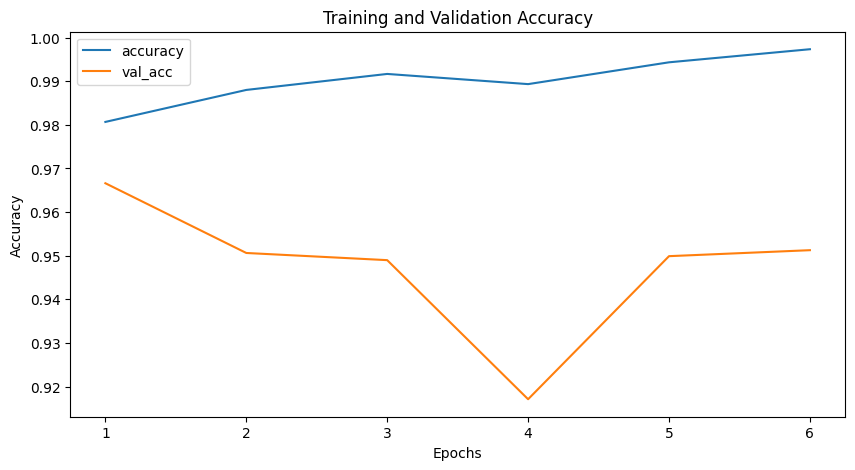

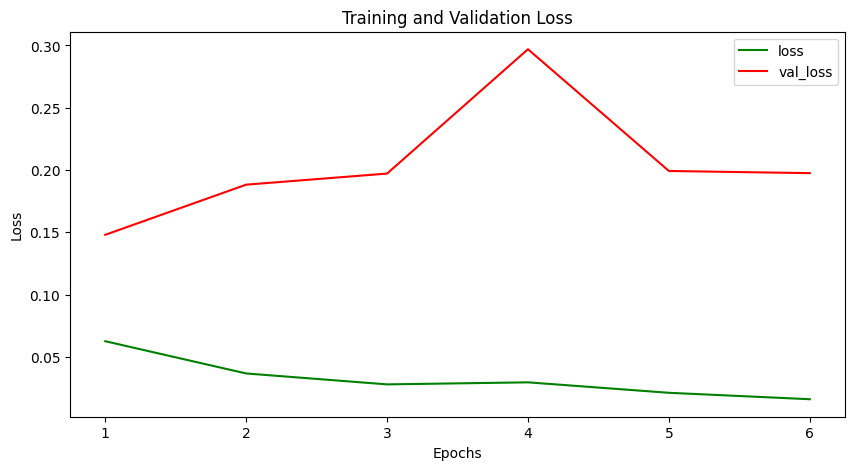

In [76]:
plt.figure(figsize=(10, 5))
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend()
plt.figure(figsize=(10, 5))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss', color='g')
plt.plot(epochs, val_loss, label='val_loss', color='r')
plt.legend()



In [78]:

y_pred_m = model.predict(X_test_new)
y_true_m = y_test_new
y_pred_classes_m = np.argmax(y_pred_m, axis=1)


685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


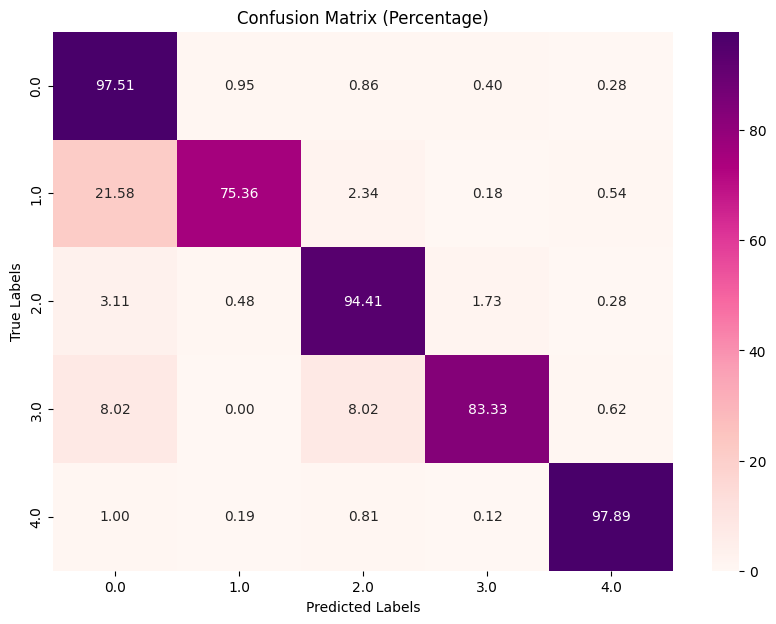

In [79]:
# Confusion Matrix
cm = confusion_matrix(y_true_m, y_pred_classes_m)

cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot Confusion Matrix Heatmap (as Percentages)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='RdPu',
            xticklabels=np.unique(y_true_m), yticklabels=np.unique(y_true_m))
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



In [80]:
# Generate Classification Report
report = classification_report(y_true_m, y_pred_classes_m)
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.98      0.98     18118
         1.0       0.70      0.75      0.72       556
         2.0       0.88      0.94      0.91      1448
         3.0       0.57      0.83      0.68       162
         4.0       0.96      0.98      0.97      1608

    accuracy                           0.97     21892
   macro avg       0.82      0.90      0.85     21892
weighted avg       0.97      0.97      0.97     21892



In [82]:
accuracy = accuracy_score(y_true_m, y_pred_classes_m)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.97


## For Nornmal Ml models

In [83]:
results = []

for model_name, model in allModels.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train_new, y_train_new)
    y_pred_k = model.predict(X_test_new)

    # Overall metrics
    accuracy = accuracy_score(y_test_new, y_pred_k)
    f1 = f1_score(y_test_new, y_pred_k, average='weighted')
    precision = precision_score(y_test_new, y_pred_k, average='weighted')
    recall = recall_score(y_test_new, y_pred_k, average='weighted')

    # Append to results
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall
    })

    # Print per-class report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test_new, y_pred_k, target_names=['0','1','2','3','4']))
    # Note: Replace `class_names` with your actual label list, like ['N', 'S', 'V', 'F', 'Q']

# Show summary
results_df = pd.DataFrame(results)
print("\nSummary Metrics:")
print(results_df)


Training Random Forest...

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     18118
           1       0.32      0.79      0.45       556
           2       0.72      0.88      0.79      1448
           3       0.12      0.91      0.22       162
           4       0.86      0.96      0.91      1608

    accuracy                           0.87     21892
   macro avg       0.60      0.88      0.66     21892
weighted avg       0.94      0.87      0.89     21892


Training Linear SVC...

Classification Report for Linear SVC:
              precision    recall  f1-score   support

           0       0.97      0.56      0.71     18118
           1       0.10      0.68      0.17       556
           2       0.30      0.67      0.42      1448
           3       0.07      0.88      0.13       162
           4       0.64      0.91      0.75      1608

    accuracy                           0.60     21892